In [1]:
from utils.imports import *

In [2]:
passengers, drivers, adj, nodes = initialize_data(True)
edited_passengers = pd.read_pickle('data/edited_passengers.pkl')
edited_drivers = pd.read_pickle('data/edited_drivers.pkl')

# B4

In [3]:
df1 = pd.read_csv('passengers.csv')
df1.columns = ['datetime', 'source_lat', 'source_lom', 'dest_lat', 'dest_lon']
df1['datetime'] = pd.to_datetime(df1['datetime'])
df1['source_node'] = pd.DataFrame(edited_passengers)[1]
df1['dest_node'] = pd.DataFrame(edited_passengers)[2]

df1['hour'] = df1.datetime.dt.hour
df1['weekend'] = df1.datetime.dt.day_of_week > 4

df2 = pd.read_csv('drivers.csv')
df2.columns = ['datetime', 'source_lat', 'source_lon']
df2['datetime'] = pd.to_datetime(df2['datetime'])
df2['node'] = pd.DataFrame(edited_drivers)[1]
df2['hour'] = df2.datetime.dt.hour
df2['weekend'] = df2.datetime.dt.day_of_week > 4


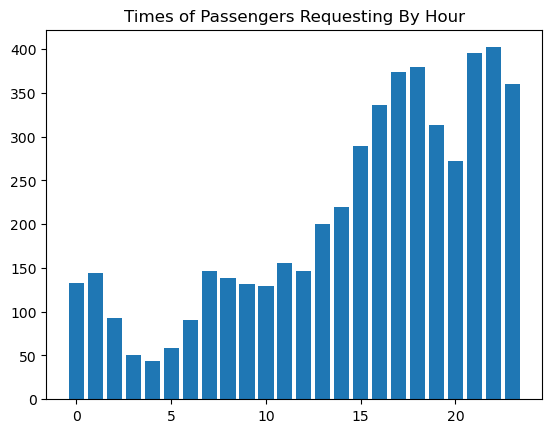

In [53]:
plt.bar(x = np.arange(0, 24), height = df1.groupby('hour')['datetime'].count())
plt.title('Times of Passengers Requesting By Hour')
plt.show()

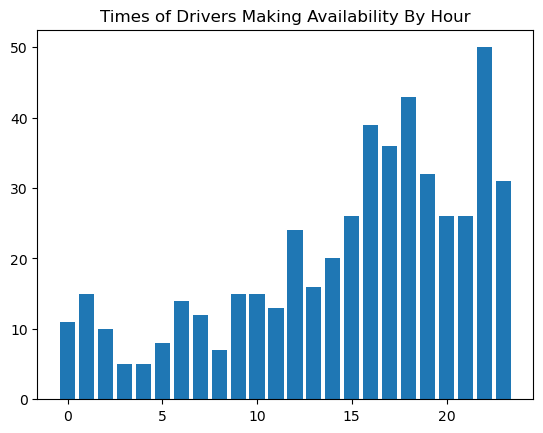

In [55]:
plt.bar(x = np.arange(0, 24), height = df2.groupby('hour')['datetime'].count())
plt.title('Times of Drivers Making Availability By Hour')
plt.show()

In [61]:
df2.groupby('node')['datetime'].count().sort_values()

node
42421737      1
42455200      1
42454997      1
42454994      1
42454742      1
             ..
42430384      3
42435910      3
42443561      4
42444909      4
1698103521    5
Name: datetime, Length: 443, dtype: int64

In [75]:
src_nodes = df1.groupby('source_node')[['datetime']].count().sort_values(by = 'datetime', ascending = False).reset_index()
src_nodes.columns = ['source_node', 'times']
src_nodes.iloc[0:10].style.set_caption("Most Common Source Nodes")  

,source_node,times
0,4633522237,33
1,42444909,22
2,1698103521,18
3,246649427,18
4,4557517555,16
5,42429633,15
6,42430384,15
7,42445953,13
8,42429412,13
9,42435596,13


In [76]:
dest_nodes = df1.groupby('dest_node')[['datetime']].count().sort_values(by = 'datetime', ascending = False).reset_index()
dest_nodes.columns = ['dest_node', 'times']
dest_nodes.iloc[0:10].style.set_caption("Most Common Dest Nodes")  

,dest_node,times
0,1698103521,39
1,4633522237,33
2,4059141532,21
3,1701651380,20
4,599041406,20
5,42435642,17
6,42429412,15
7,42430384,14
8,2087152389,13
9,4443775465,13


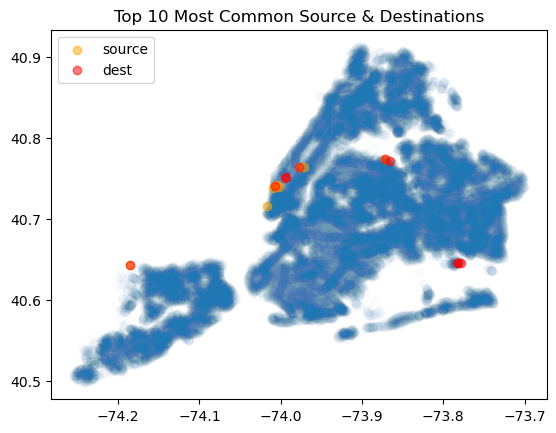

In [98]:
nodes_df = pd.DataFrame(nodes).T.reset_index()
nodes_df.columns = ['node', 'lon', 'lat']

dest_nodes_df = nodes_df.loc[nodes_df['node'].isin(dest_nodes.iloc[0:10]['dest_node'])]
src_nodes_df = nodes_df.loc[nodes_df['node'].isin(src_nodes.iloc[0:10]['source_node'])]

plt.scatter(nodes_df['lon'], nodes_df['lat'], alpha = 0.01)
plt.scatter(src_nodes_df['lon'], src_nodes_df['lat'], alpha = 0.5, color = 'orange', label = 'source')
plt.scatter(dest_nodes_df['lon'], dest_nodes_df['lat'], alpha = 0.5, color = 'red', label = 'dest')
plt.legend()
plt.title("Top 10 Most Common Source & Destinations")
plt.show()

# B3

In [99]:
'''
Improvements to Algorithm
1) Direct Driver Flow Towards Hotspot Areas -> Bonus for Operating in High Imbalance Region
a) Total Bonus = (#Customers/#Available Drivers) * Constant
2) Direct Driver Flow Towards High-Population Sides (Greatest Uncertainty)

How to Determine High Demand with High Probability (In Terms of Source Nodes)
1) Create a 3D Function
a) Axis Longitude [-74.2 to - 73.7]
b) Axis Latitude [40.5 to 40.9]
c) Time [0 - 24]

1) Fit a Gaussian Process Reward Function: 
- (Average Waiting Time on a Node) * Sigmoid(log(#Number Available Customers/#Drivers) + c * # Customers)
a) Regions High Under Function (Penalty For Drivers In That Region)
b) Regions Low Under Function (Reward Drivers In That Region)
2) Adaptable: By Bayes Law, we can continuously update distribution in order to balance out the kinks in the data

Algorithm
1) Build Forecasting Model using Gaussian Process
2) Find Predicted Over & Under Demanded Areas
3) For Every Additional Driver Over & Under Limit -> Incentivize them to leave & continue in the area
a) Create Driver Scheduling to Go from Overserved to Underserved Areas (If Drivers outmatch predicted demand)
b) Discount Payment (Going to Underserved) In order to get more customers

'''

'\nImprovements to Algorithm\n1) Direct Driver Flow Towards Hotspot Areas -> Bonus for Operating in High Imbalance Region\na) Total Bonus = (#Customers/#Available Drivers) * Constant\n'

In [4]:
'''
Dynamic Updating of Edges - Number of Cars Using Road

1) The route algorithm calculates the predicted speed for each edge at a predicted time when it chooses a route
a) For example, an edge at time A may be different than an edge at time B based on number of dribers
2) When someone is matched to a driver, add that driver as an interval on each edge 
3) Save all of this information for each edge as a segment tree [each segment is a time interval]
4) When calculating distance in Dijkstra's or AStar, save maximum number of overlapping intervals in the segment tree

5) How to compute speed
1 mile = 5280 feet
Average Car Size = 15 Feet Long

x = length of road
y = size of car (15/5280)
z = number of cars

New_Speed = Speed * max(((x - y * z)/x)^2, 0.1)

Slide_One: Summary of Solution
Slide_Two: Segment Tree Information
Slide_Three: Explanation of Algorithm
Slide_Four: Rationale for Equation

'''

'\nDynamic Updating of Number of Cars Using Road\n\n\n'

# B2

In [140]:
state_info = {0.3:{}, 0:{}}

In [152]:
def find_driverb2(passenger, drivers, nodes, adj, find_path, slower_ratio = 0):
    nodes_label = pd.read_pickle('data/nodes_label.pkl')
    node_dists = pd.read_pickle('data/node_dists.pkl')
    
    closest_node = None
    closest_dist = float('inf')
    passenger_node = passenger[1]
    
    for i in range(len(drivers)):
        driver = drivers[i]
        driver_node = driver[1]
        driver_id = driver[-1]
        
        if driver_id not in state_info[slower_ratio]:
            state_info[slower_ratio][driver_id] = 1
        
        if driver[0] > passenger[0]:
            state_info[slower_ratio][driver_id] += 1
            return closest_node
        
        ratio = 1 + state_info[slower_ratio][driver_id] * slower_ratio
        dist = node_dists[(nodes_label[driver_node], nodes_label[passenger_node])] * ratio + ratio
        
        if dist < closest_dist:
            closest_dist = dist
            closest_node = (driver, i)
        
        if dist == 0:
            state_info[slower_ratio][driver_id] += 1
            return closest_node

In [153]:
res_cus, res_driv, res_time = match(fast_get_closest_node, find_driverb2, astar)

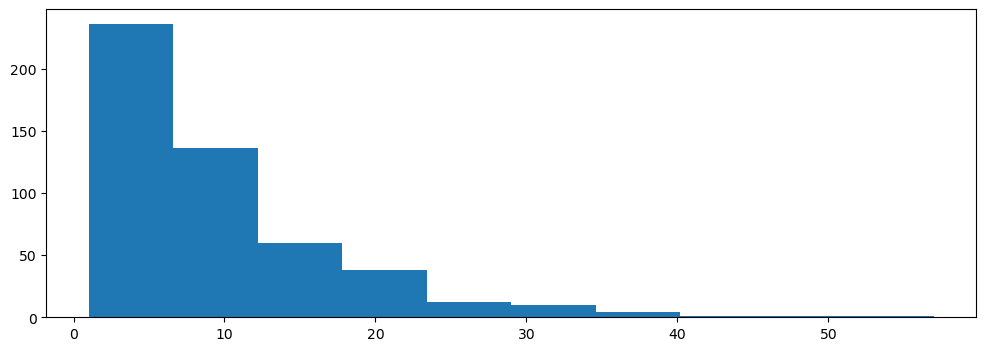

9.366733466933868

In [143]:
plt.hist(list(state_info[0.3].values()))
plt.show()
values = np.array(list(state_info[0.3].values()))
values.mean()

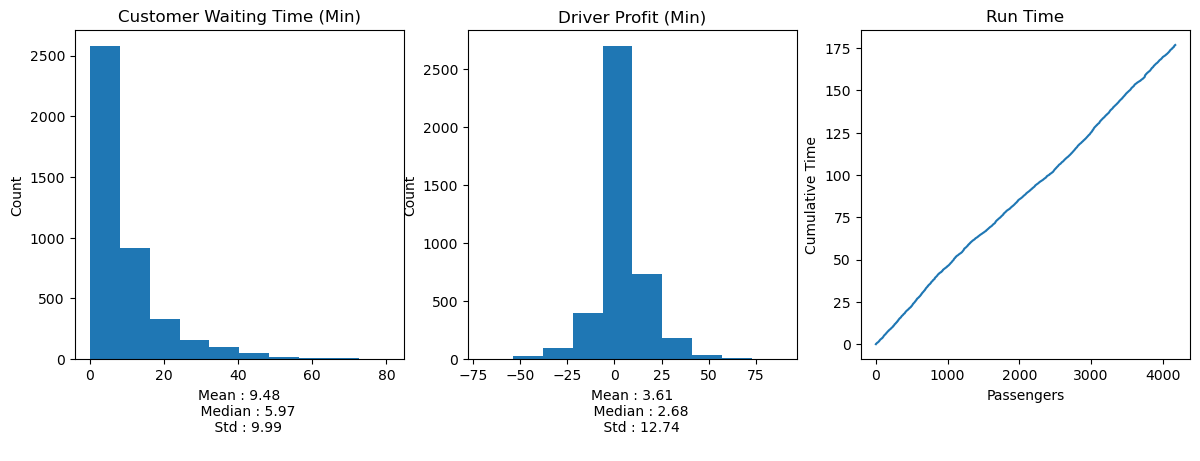

In [144]:
process_results(res_cus, res_driv, res_time)

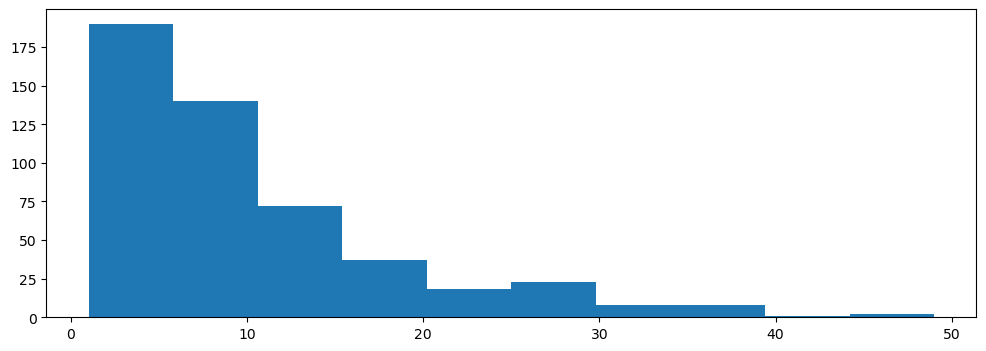

10.08817635270541

In [154]:
plt.hist(list(state_info[0].values()))
plt.show()
values = np.array(list(state_info[0].values()))
values.mean()

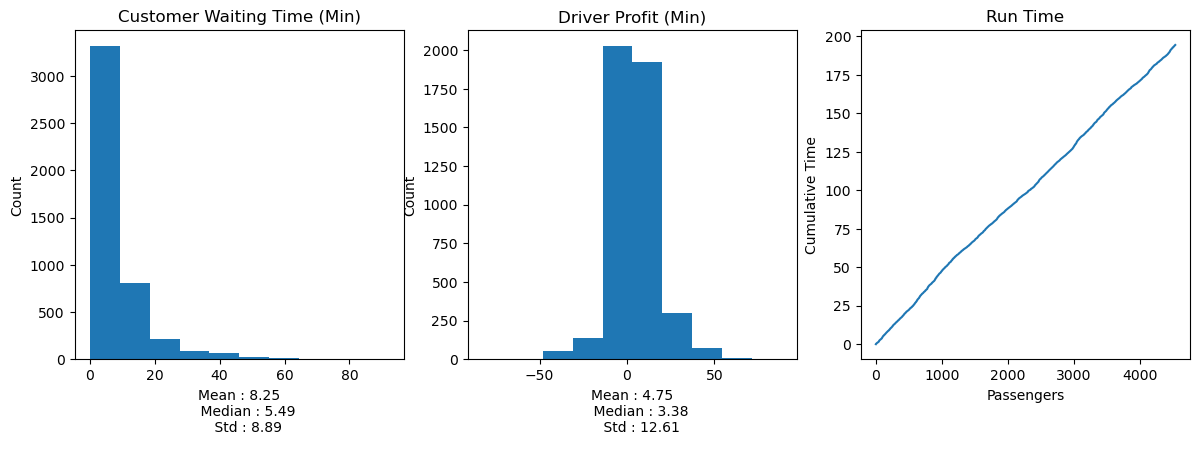

In [155]:
process_results(res_cus, res_driv, res_time)

In [151]:
state_info[0] = {}